# Import Libraries

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import cv2
import os

# Load the Sign Language MNIST data

In [7]:
train_df = pd.read_csv('data/sign_mnist_train.csv')
test_df = pd.read_csv('data/sign_mnist_test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Number of classes: {train_df['label'].nunique()}")

Training data shape: (27455, 785)
Test data shape: (7172, 785)
Number of classes: 24


# Prepare the data

In [30]:
# Prepare the data
# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

# Check unique labels
print("Unique labels in training data:", np.unique(y_train))
print("Max label value:", np.max(y_train))

# The dataset has labels 0-25 (excluding 9=J and 25=Z)
# We need to map these to 0-23 for our 24 classes
label_map = {}
new_label = 0
for i in range(26):
    if i == 9:  # Skip J (label 9)
        continue
    label_map[i] = new_label
    new_label += 1

# Apply label mapping
y_train = np.array([label_map.get(label, label) for label in y_train])
y_test = np.array([label_map.get(label, label) for label in y_test])

print("\nAfter mapping:")
print("Unique labels in training data:", np.unique(y_train))
print("Max label value:", np.max(y_train))

# Reshape data to 28x28 images
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Unique labels in training data: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Max label value: 24

After mapping:
Unique labels in training data: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Max label value: 23

X_train shape: (27455, 28, 28, 1)
X_test shape: (7172, 28, 28, 1)


Label Mapping:
Label 0 = Letter A
Label 1 = Letter B
Label 2 = Letter C
Label 3 = Letter D
Label 4 = Letter E
Label 5 = Letter F
Label 6 = Letter G
Label 7 = Letter H
Label 8 = Letter I
Label 9 = Letter K
Label 10 = Letter L
Label 11 = Letter M
Label 12 = Letter N
Label 13 = Letter O
Label 14 = Letter P
Label 15 = Letter Q
Label 16 = Letter R
Label 17 = Letter S
Label 18 = Letter T
Label 19 = Letter U
Label 20 = Letter V
Label 21 = Letter W
Label 22 = Letter X
Label 23 = Letter Y


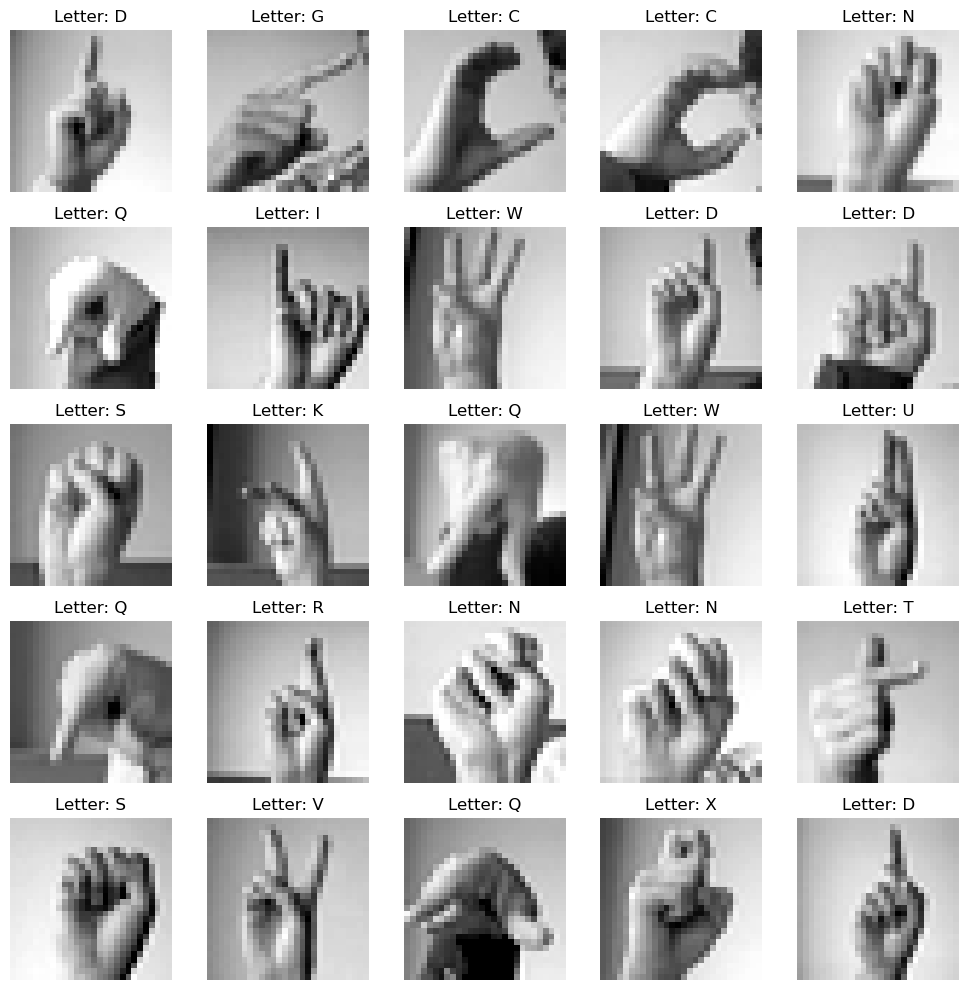

In [32]:
# Define class names (A-Z excluding J and Z)
CLASSES = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 
           'V', 'W', 'X', 'Y']

# Display label mapping
print("Label Mapping:")
for i, letter in enumerate(CLASSES):
    print(f"Label {i} = Letter {letter}")

# Display some sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Letter: {CLASSES[y_train[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Build the CNN model

In [34]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(24, activation='softmax')  # 24 classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,696 (518.34 KB)

 Trainable params: 132,696 (518.34 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1386 - loss: 2.8586 - val_accuracy: 0.7104 - val_loss: 1.0520
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6124 - loss: 1.1842 - val_accuracy: 0.8417 - val_loss: 0.4969
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7596 - loss: 0.7050 - val_accuracy: 0.9228 - val_loss: 0.2770
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8406 - loss: 0.4641 - val_accuracy: 0.9638 - val_loss: 0.1591
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8810 - loss: 0.3425 - val_accuracy: 0.9825 - val_loss: 0.0890
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9136 - loss: 0.2510 - val_accuracy: 0.9865 - val_loss: 0.0630
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9326 - loss: 0.1946 - val_accuracy: 0.9954 - val_loss: 0.0326
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9554 - loss: 0.1413 - val_accu

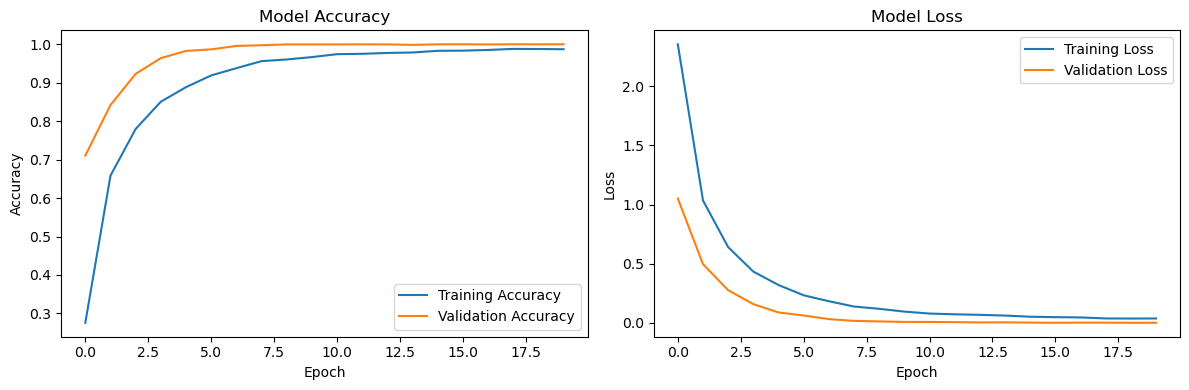

In [38]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Check if accuracy is above 70%
if test_accuracy >= 0.70:
    print("✅ Model meets the 70% accuracy requirement!")
else:
    print("❌ Model accuracy is below 70%. Need to improve.")

Test Accuracy: 94.42%
✅ Model meets the 70% accuracy requirement!


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Weighted Precision: 0.9463
Weighted Recall: 0.9442
Weighted F1-Score: 0.9437


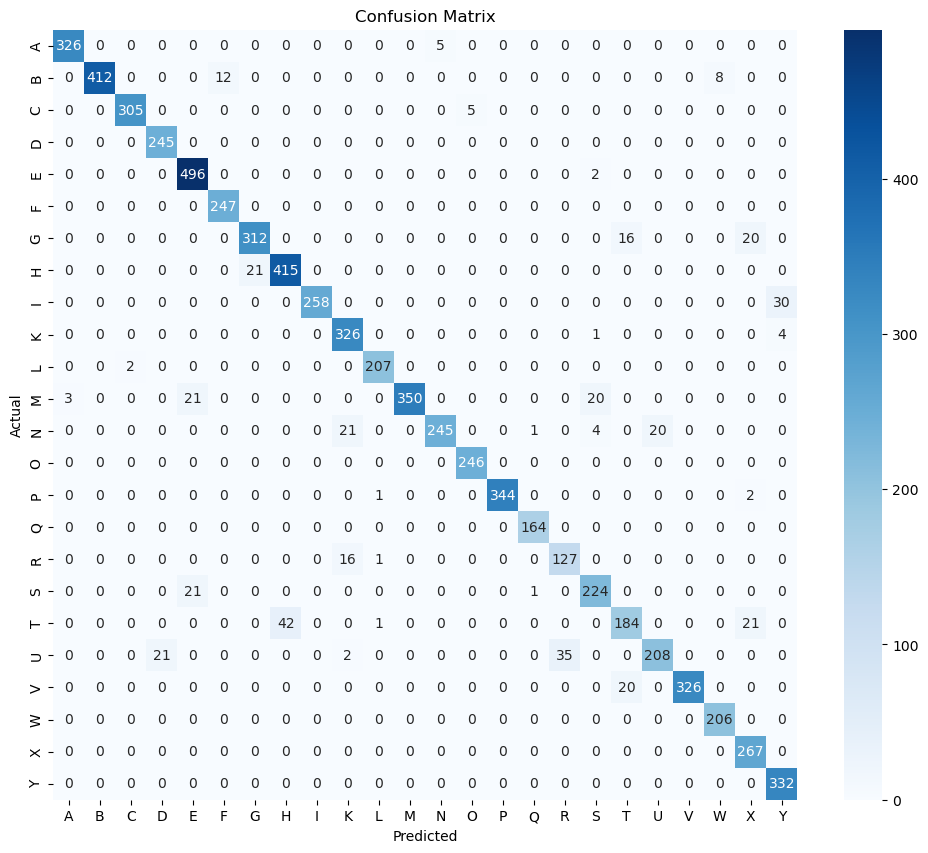


Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.98      0.99       331
           B       1.00      0.95      0.98       432
           C       0.99      0.98      0.99       310
           D       0.92      1.00      0.96       245
           E       0.92      1.00      0.96       498
           F       0.95      1.00      0.98       247
           G       0.94      0.90      0.92       348
           H       0.91      0.95      0.93       436
           I       1.00      0.90      0.95       288
           K       0.89      0.98      0.94       331
           L       0.99      0.99      0.99       209
           M       1.00      0.89      0.94       394
           N       0.98      0.84      0.91       291
           O       0.98      1.00      0.99       246
           P       1.00      0.99      1.00       347
           Q       0.99      1.00      0.99       164
           R       0.78      0.88      0.83       144
   

In [42]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f"\nWeighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=CLASSES))

In [44]:
# Save the model
os.makedirs('models', exist_ok=True)
model.save('models/sign_language_model.h5')
print("Model saved successfully!")

# Save class names
import pickle
with open('models/classes.pkl', 'wb') as f:
    pickle.dump(CLASSES, f)
print("Classes saved!")

Model saved successfully!
Classes saved!
